# k-means Clustering

## Table of contents

[1.) Simple k-means clustering example](#section_1)<br>
[2.) Image segmentation](#section_2)<br>
[3.) 3D point cloud segmentation](#section_3)<br>
[4.) Finding clusters in the apartment data](#section_4)

## Libraries and settings

In [3]:
# Libraries
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Current working directory
print('\nCurrent working directory:', os.getcwd())


Current working directory: c:\Users\lukas\OneDrive\Prototyping\SBBAnalytics\SBBAnalytics


## 1.) Simple k-means clustering example
<a id='section_1'></a>

### Create the dataset

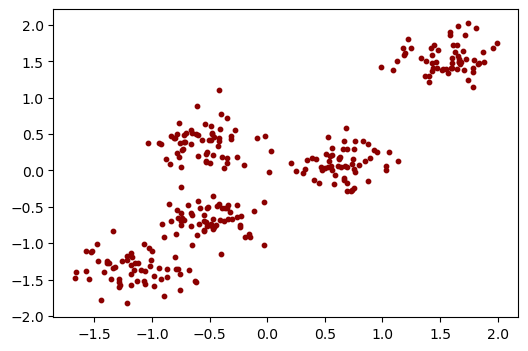

In [4]:
# Create data
centers = [[2,1], [-2,2], [-2,-2], [-4,-5], [5,7]]
X, y = make_blobs(n_samples=300, 
                  centers=centers, 
                  cluster_std=0.8,
                  random_state=42)

# Normalization of the values
X = StandardScaler().fit_transform(X)

# Plot the data
plt.figure(figsize=(6,4))
plt.scatter(X[:,0], X[:,1], s=10, color='darkred')
plt.show()

### Elbow Method showing the optimal k

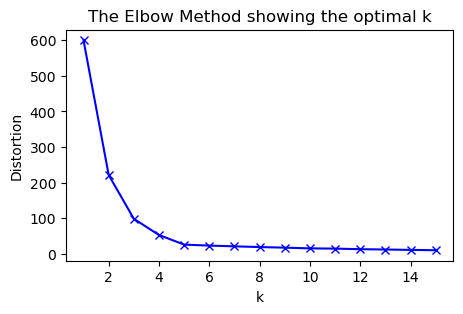

In [6]:
# Sum of squared distances of samples to their closest cluster center
distortions = []

# Range of k's
K = range(1, 16)

# Loop to find the optimal k
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X)
    distortions.append(kmeanModel.inertia_)
    
# Elbow plot
plt.figure(figsize=(5, 3))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

### Perform k-means clustering

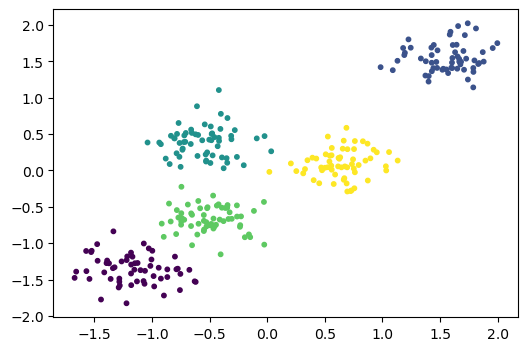

In [8]:
# Number of clusters
k = 5

# k-means clustering
kmeans = KMeans(n_clusters=k, random_state=42).fit(X)

# Predict the values
y2 = kmeans.predict(X)

# Plot the clusters
plt.figure(figsize=(6,4))
plt.scatter(X[:, 0], X[:, 1], c=y2, s=10)
plt.show()

### Get and check the converged cluster centroids

In [11]:
# Print centroids
centroids = kmeans.cluster_centers_
print('Cluster centroids:')
print(centroids, '\n')

# Check the 1st cluster's centroid 'by hand'
clust_00 = X[y2 == 0]
print('The 1st cluster\'s centroid:')
print(f'x = {sum(clust_00[:,0]/len(clust_00[:,0])):.8f}')
print(f'y = {sum(clust_00[:,1]/len(clust_00[:,1])):.8f}')

Cluster centroids:
[[-1.16214999 -1.36217282]
 [ 1.56276666  1.54186443]
 [-0.55467879  0.3889481 ]
 [-0.49867406 -0.67040574]
 [ 0.64167824  0.09023659]] 

The 1st cluster's centroid:
x = -1.16214999
y = -1.36217282


### Get the inertia or 'within-cluster sum-of-squares (WCSS)' of the k-means model

In [12]:
print(f'Within-cluster sum-of-squares: {kmeans.inertia_:.4f}')

Within-cluster sum-of-squares: 26.3487


## 4.) Finding clusters in the apartment data
<a id='section_4'></a>

### Import the passagierfrequenz data

In [13]:
import pandas as pd

columns = ['Code', 
           'Bahnhof', 
           'Kanton', 
           'Jahr', 
           'DTV']

# Lese die Datei und wähle die relevanten Variablen aus
df_orig = pd.read_csv("data_prepared.csv", 
                      sep=",", 
                      encoding="utf-8")[columns]

# Benenne die Spalte 'Code' um in 'station_id'
df_orig = df_orig.rename(columns={'Code': 'station_id'})

# Entferne fehlende Werte
df = df_orig.dropna()

# Entferne Duplikate
df = df.drop_duplicates()

# Filtere nur Einträge mit einem Verkehrswert zwischen 1.000 und 50.000
df = df.loc[(df['DTV'] >= 1000) & 
            (df['DTV'] <= 50000)]

# Zeige die Form und die ersten 5 Zeilen des bereinigten DataFrames
print(df.shape)
df.head(5)

(1225, 5)


,station_id,Bahnhof,Kanton,Jahr,DTV
4,ABO,Aarburg-Oftringen,AG,2022,2500
10,ALT,Altstätten SG,SG,2023,4300
11,AND,Andermatt,UR,2018,2700
12,ARB,Arbon,TG,2018,1700
16,AU,Au ZH,ZH,2023,1100


### Subset of the passagierfrequenz data frame for k-means clustering

In [14]:
# Define a subset of the data frame for k-means clustering
X3 = df[['station_id',
          'Jahr',
           'DTV']]

### Elbow method showing the optimal k

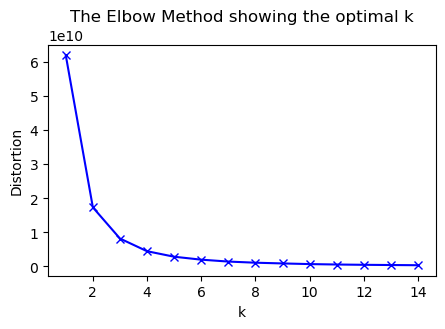

In [18]:
# Sum of squared distances of samples to their closest cluster center
distortions = []

# Range of k's
K = range(1, 15)

# Loop to find the optimal k
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X3[['Jahr', 'DTV']])
    distortions.append(kmeanModel.inertia_)
    
# Elbow plot
plt.figure(figsize=(5, 3))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

### Perform k-means clustering on the passagierfrequenz data

In [19]:
# Number of clusters
k = 5

# Perform k-means clustering
kmeans_apmts = KMeans(n_clusters=k, random_state=42).fit(X3[['Jahr', 'DTV']])

# Add the clusters to data frame
X3['cluster'] = kmeans_apmts.predict(X3[['Jahr', 'DTV']])

# Show number of stations per cluster
X3['cluster'].value_counts().sort_values(ascending=False)

cluster
2    802
0    252
4    101
1     47
3     23
Name: count, dtype: int64

### Plot the passagierfrequenz clusters

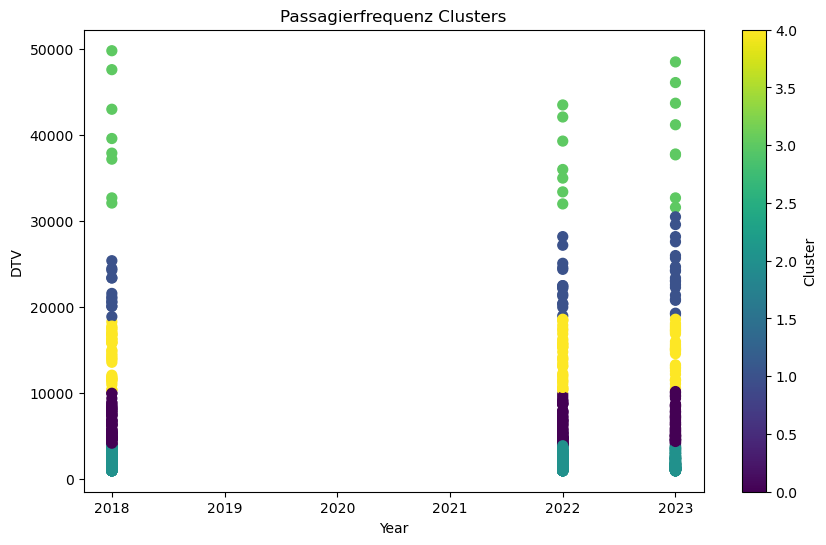

In [21]:
# Plot the passagierfrequenz clusters
plt.figure(figsize=(10, 6))
plt.scatter(X3['Jahr'], X3['DTV'], c=X3['cluster'], cmap='viridis', s=50)
plt.xlabel('Year')
plt.ylabel('DTV')
plt.title('Passagierfrequenz Clusters')
plt.colorbar(label='Cluster')
plt.show()

### Calculate the Silhouette Score

In [23]:
from sklearn.metrics import silhouette_score

# Calculate the Silhouette Score
silhouette_avg = silhouette_score(X, y2)
print(f'Silhouette Score: {silhouette_avg:.4f}')

Silhouette Score: 0.6597


### Jupyter notebook --footer info-- (please always provide this at the end of each submitted notebook)

In [ ]:
import os
import platform
import socket
from platform import python_version
from datetime import datetime

print('-----------------------------------')
print(os.name.upper())
print(platform.system(), '|', platform.release())
print('Datetime:', datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
print('Python Version:', python_version())
print('-----------------------------------')